In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.datasets import cifar10
from keras.utils import np_utils

from keras.models import Sequential,Model 
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D 
from keras.layers import ZeroPadding2D,Activation,Input
from keras import optimizers,regularizers
from keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report

# 匯入資料集

In [4]:
(x_train_image, y_train_label), (x_test_image, y_test_label)=cifar10.load_data()

# 資料預處理

In [3]:
x_train_normalize=x_train_image.astype('float32')/255.0
x_test_normalize=x_test_image.astype('float32')/255.0

In [4]:
y_train_onehot=np_utils.to_categorical(y_train_label)
y_test_onehot=np_utils.to_categorical(y_test_label)

In [5]:
x_train=x_train_normalize[:40000]
x_valid=x_train_normalize[-10000:]
y_train=y_train_onehot[:40000]
y_valid=y_train_onehot[-10000:]

# 設置好超參數

In [6]:
num_classes        = 10
batch_size         = 64         # 64 or 32 or other
epochs             = 150
iterations         = 782       
DROPOUT=0.5 # keep 50%
CONCAT_AXIS=3
weight_decay=1e-4
DATA_FORMAT='channels_last' # Theano:'channels_first' Tensorflow:'channels_last'
log_filepath  = './alexnet'

# 設置learning schedule

In [7]:
def scheduler(epoch):
    if epoch < 100:
        return 0.01
    if epoch < 200:
        return 0.001
    return 0.0001

# 建構網路

In [8]:
def alexnet(img_input,classes=10):
    x = Conv2D(96,(11,11),strides=(4,4),padding='same',
               activation='relu',kernel_initializer='uniform')(img_input)# valid
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same',data_format=DATA_FORMAT)(x)
    
    x = Conv2D(256,(5,5),strides=(1,1),padding='same',
               activation='relu',kernel_initializer='uniform')(x)
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same',data_format=DATA_FORMAT)(x)
    
    x = Conv2D(384,(3,3),strides=(1,1),padding='same',
               activation='relu',kernel_initializer='uniform')(x) 
    
    x = Conv2D(384,(3,3),strides=(1,1),padding='same',
               activation='relu',kernel_initializer='uniform')(x) 
    
    x = Conv2D(256,(3,3),strides=(1,1),padding='same',
               activation='relu',kernel_initializer='uniform')(x)
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same',data_format=DATA_FORMAT)(x)
    x = Flatten()(x)
    x = Dense(4096,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096,activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(classes, activation='softmax')(x)
    return out

# 生成模型

In [9]:
img_input=Input(shape=(32,32,3))
output = alexnet(img_input)
model=Model(img_input,output)
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 96)          34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 384)         885120    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 384)         132

# training

In [10]:
# set optimizer
sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# set callback
tb_cb = TensorBoard(log_dir=log_filepath, histogram_freq=0)
change_lr = LearningRateScheduler(scheduler)
cbks = [change_lr,tb_cb]

# set data augmentation
datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.125,
                             height_shift_range=0.125,
                             fill_mode='constant',cval=0.)
datagen.fit(x_train)

# start training
my_alexnet_model=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks,
                    validation_data=(x_valid, y_valid))
model.save('alexnet.h5')




Epoch 1/150
782/782 [==============================] - 19s 24ms/step - loss: 1.8936 - accuracy: 0.2852 - val_loss: 1.5740 - val_accuracy: 0.4277

Epoch 2/150
782/782 [==============================] - 18s 23ms/step - loss: 1.5517 - accuracy: 0.4307 - val_loss: 1.4217 - val_accuracy: 0.4920
Epoch 3/150
782/782 [==============================] - 17s 22ms/step - loss: 1.4271 - accuracy: 0.4782 - val_loss: 1.3216 - val_accuracy: 0.5207
Epoch 4/150
782/782 [==============================] - 17s 22ms/step - loss: 1.3377 - accuracy: 0.5153 - val_loss: 1.2835 - val_accuracy: 0.5425
Epoch 5/150
782/782 [==============================] - 17s 22ms/step - loss: 1.2657 - accuracy: 0.5452 - val_loss: 1.1849 - val_accuracy: 0.5750
Epoch 6/150
782/782 [==============================] - 17s 22ms/step - loss: 1.2136 - accuracy: 0.5642 - val_loss: 1.1763 - val_accuracy: 0.5921
Epoch 7/150
782/782 [==============================] - 17s 22ms/step - loss: 1.1555 - accuracy: 0.5876 - val_loss: 1.1166 - va

782/782 [==============================] - 17s 21ms/step - loss: 0.0272 - accuracy: 0.9904 - val_loss: 1.5974 - val_accuracy: 0.7049
Epoch 108/150
782/782 [==============================] - 17s 21ms/step - loss: 0.0268 - accuracy: 0.9915 - val_loss: 1.6142 - val_accuracy: 0.7020
Epoch 109/150
782/782 [==============================] - 17s 21ms/step - loss: 0.0253 - accuracy: 0.9915 - val_loss: 1.6543 - val_accuracy: 0.7032
Epoch 110/150
782/782 [==============================] - 17s 21ms/step - loss: 0.0252 - accuracy: 0.9911 - val_loss: 1.6581 - val_accuracy: 0.7074
Epoch 111/150
782/782 [==============================] - 17s 21ms/step - loss: 0.0246 - accuracy: 0.9917 - val_loss: 1.6861 - val_accuracy: 0.7063
Epoch 112/150
782/782 [==============================] - 17s 21ms/step - loss: 0.0226 - accuracy: 0.9918 - val_loss: 1.7247 - val_accuracy: 0.7072
Epoch 113/150
782/782 [==============================] - 17s 21ms/step - loss: 0.0210 - accuracy: 0.9931 - val_loss: 1.7395 - val_ac

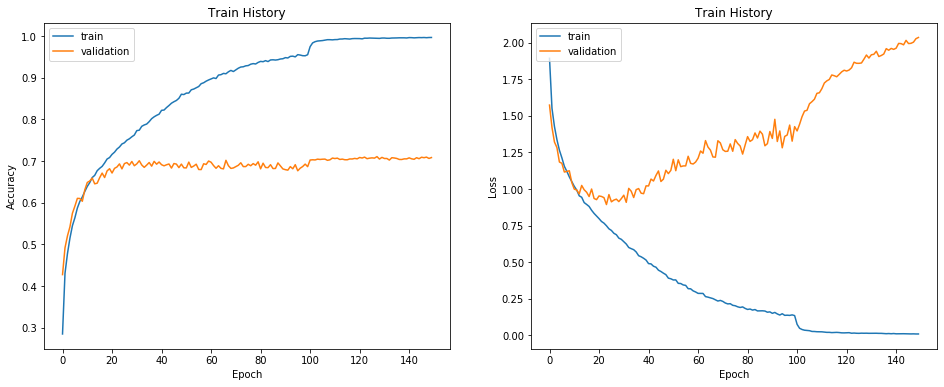

In [11]:
def show_train_history(train_history):
...     fig=plt.gcf()
...     fig.set_size_inches(16, 6)
...     plt.subplot(121)
...     plt.plot(train_history.history["accuracy"])
...     plt.plot(train_history.history["val_accuracy"])
...     plt.title("Train History")
...     plt.xlabel("Epoch")
...     plt.ylabel("Accuracy")
...     plt.legend(["train", "validation"], loc="upper left")
...     plt.subplot(122)
...     plt.plot(train_history.history["loss"])
...     plt.plot(train_history.history["val_loss"])
...     plt.title("Train History")
...     plt.xlabel("Epoch")
...     plt.ylabel("Loss")
...     plt.legend(["train", "validation"], loc="upper left")
...     plt.show()
show_train_history(my_alexnet_model)

In [12]:
scores=model.evaluate(x_test_normalize, y_test_onehot)
print("Accuracy=", scores[1])

10000/10000 [==============================] - 1s 122us/step
Accuracy= 0.7006000280380249


In [13]:
predict = model.predict(x_test_normalize)
predict=np.argmax(predict,axis=1)
pd.crosstab(y_test_label.reshape(-1), predict, rownames=['label'],colnames=['predict'])

predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,814,18,36,7,14,6,10,15,54,26
1,32,775,10,8,2,8,8,5,26,126
2,81,9,592,71,66,54,69,35,12,11
3,29,19,52,500,47,187,78,48,17,23
4,40,5,92,66,567,47,74,87,9,13
5,19,5,50,185,49,561,39,70,12,10
6,9,8,41,56,30,34,799,8,7,8
7,23,1,16,41,40,58,8,793,5,15
8,75,25,9,12,9,13,2,3,821,31


In [17]:
print(classification_report(y_test_label, predict))

              precision    recall  f1-score   support

           0       0.69      0.81      0.75      1000
           1       0.83      0.78      0.80      1000
           2       0.65      0.59      0.62      1000
           3       0.52      0.50      0.51      1000
           4       0.68      0.57      0.62      1000
           5       0.57      0.56      0.57      1000
           6       0.73      0.80      0.76      1000
           7       0.73      0.79      0.76      1000
           8       0.83      0.82      0.83      1000
           9       0.75      0.78      0.77      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000

